In [1]:
import PIL
import requests
import torch
from io import BytesIO

from diffusers import StableDiffusionInpaintPipeline
# app/main.py
import base64
import io
import json
import random
import re
from io import BytesIO

import numpy as np
import requests
import torch
from PIL import Image
import torchvision.transforms as T
from torchvision import transforms
from ultralytics import YOLO
from ultralytics.models.sam import Predictor as SAMPredictor

import matplotlib.pyplot as plt


/Users/valentinafeve/Projects/Close/diffusers-try-on-clothing/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load a pretrained YOLOv8n model
MODEL_PATH = 'model.pt'
model = YOLO(MODEL_PATH)

In [3]:
transform = T.ToPILImage()
inversed_transform = T.ToTensor()

In [4]:
def box_cxcywh_to_xyxy(x):
    """
    Converts boxes from format (center_x, center_y, width, heigth) to format (min_x, min_y, max_x, max_y)
    :param x: Box matching the format cxcywh
    :return: Tensor containing the new box with the format xyxy.
    """
    x_c, y_c, w, h = x.unbind(0)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b)


In [5]:
def run_yolos(image):
    # Load a pretrained YOLOv8n model
    print("Loading model...")

    # Run inference on 'bus.jpg'
    print("Running inference...")
    results = model([image], save=False)[0]  # results list
    return results

def run_sam_prediction(image, bbox):
    # Create SAMPredictor
    overrides = dict(conf=0.25, task='segment', mode='predict', imgsz=1024, model="mobile_sam.pt", save=False)
    predictor = SAMPredictor(overrides=overrides)

    # Set image
    img_np = np.array(image)
    predictor.set_image(img_np)

    print("Running SAM...")
    sam_results = predictor(bboxes=bbox, save=False)[0]

    return sam_results

In [6]:
def download_image(url):
    response = requests.get(url)
    return PIL.Image.open(BytesIO(response.content)).convert("RGB")


In [7]:
img_url = "IMG_0570.jpg"
init_image = Image.open(img_url).resize((512, 512))

In [8]:
results = run_yolos(init_image)

Loading model...
Running inference...

0: 640x640 1 bracelet, 1 pants, 1 necklace, 262.3ms
Speed: 3.8ms preprocess, 262.3ms inference, 5.4ms postprocess per image at shape (1, 3, 640, 640)


In [9]:
results.boxes.conf

tensor([0.9778, 0.8919, 0.5690])

In [10]:
boxes = results.boxes.xywh
box_classes = results.boxes.cls
confs = results.boxes.conf

print(f"Found {len(boxes)} boxes")

Found 3 boxes


In [11]:
def expand_mask(mask, radius):
    t_image = mask.clone()

    t_zeros = torch.zeros_like(t_image)
    for i in range(1, radius):
        cropped_bottom_right = t_image[:, i:, i:]
        t_zeros[:, :-i, :-i] += cropped_bottom_right

        cropped_top_left = t_image[:, :-i, :-i]
        t_zeros[:, i:, i:] += cropped_top_left

        cropped_bottom_left = t_image[:, i:, :-i]
        t_zeros[:, :-i, i:] += cropped_bottom_left

        cropped_top_right = t_image[:, :-i, i:]
        t_zeros[:, i:, :-i] += cropped_top_right

        cropped_top = t_image[:, i:, :]
        t_zeros[:, :-i, :] += cropped_top

        cropped_left = t_image[:, :, i:]
        t_zeros[:, :, :-i] += cropped_left

        cropped_right = t_image[:, :, :-i]
        t_zeros[:, :, i:] += cropped_right

        cropped_bottom = t_image[:, :-i, :]
        t_zeros[:, i:, :] += cropped_bottom

    t_zeros = torch.clamp(t_zeros, 0, 1)
    return t_zeros

In [12]:
masks = []    
print("Iterating over boxes...")
for box_class, box, conf in zip(box_classes, boxes, confs):
    if conf < 0.5:
        continue
    bbox = box_cxcywh_to_xyxy(box)

    sam_results = run_sam_prediction(init_image, bbox)

    print("Generating masked image...")

    expanded_mask = expand_mask(sam_results.masks.data, 5)
    img = transform(expanded_mask * 1.0)
    img.save(f"masked_{box_class}.jpg")
   

Iterating over boxes...
Ultralytics YOLOv8.0.226 🚀 Python-3.11.4 torch-2.1.2 CPU (Apple M2)
Running SAM...

0: 1024x1024 53.7ms
Speed: 0.0ms preprocess, 53.7ms inference, 1.1ms postprocess per image at shape (1, 3, 1024, 1024)
Generating masked image...
Ultralytics YOLOv8.0.226 🚀 Python-3.11.4 torch-2.1.2 CPU (Apple M2)
Running SAM...

0: 1024x1024 38.1ms
Speed: 0.0ms preprocess, 38.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Generating masked image...
Ultralytics YOLOv8.0.226 🚀 Python-3.11.4 torch-2.1.2 CPU (Apple M2)
Running SAM...

0: 1024x1024 45.5ms
Speed: 0.0ms preprocess, 45.5ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
Generating masked image...


In [13]:
mask_url = "masked_6.0.jpg"
mask_image = Image.open(mask_url).resize((512, 512))

(512, 512)


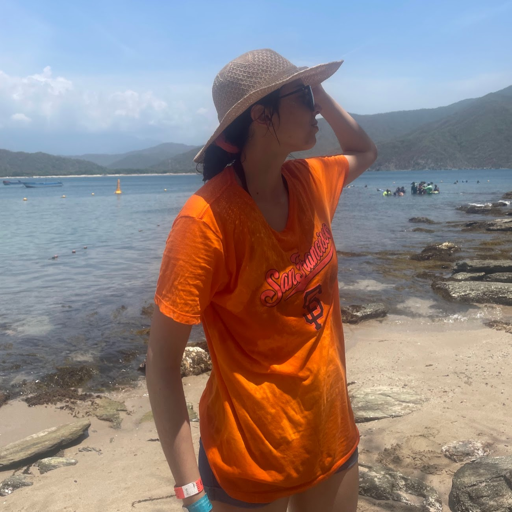

In [14]:
print(init_image.size)
init_image

(512, 512)


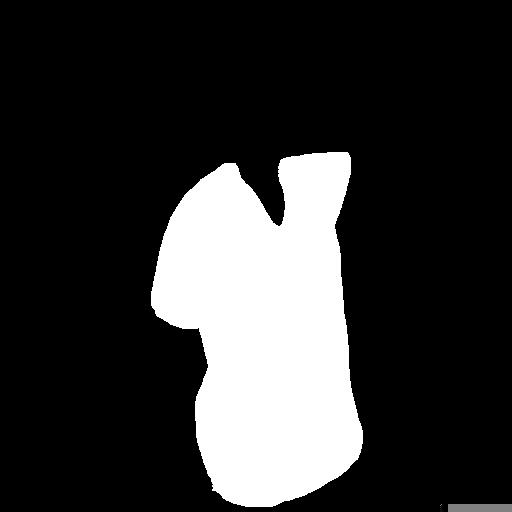

In [15]:
print(mask_image.size)
mask_image

torch.Size([3, 512, 512])
torch.Size([3, 512, 512])


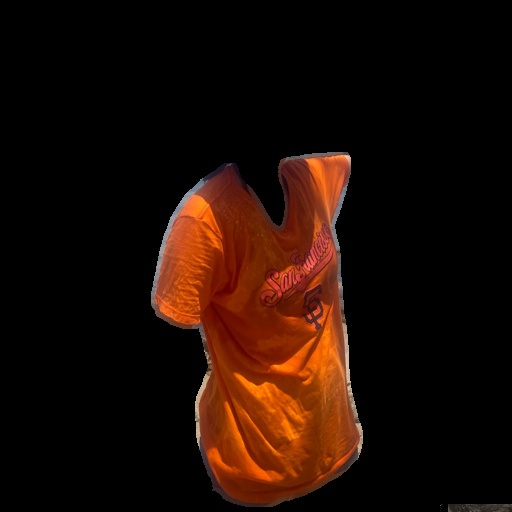

In [16]:
mask_with_channels = torch.stack([inversed_transform(mask_image)[0]] * 3, dim=0)
print(mask_with_channels.shape)

t_init_image = inversed_transform(init_image)
print(t_init_image.shape)

masked_image = t_init_image * mask_with_channels
transform(masked_image)

In [17]:

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16
)
pipe = pipe.to("mps")

prompt = "A pink t-shirt."
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

safety_checker/model.safetensors not found
Loading pipeline components...:  57%|█████▋    | 4/7 [00:04<00:04,  1.38s/it]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
100%|██████████| 50/50 [01:05<00:00,  1.31s/it]


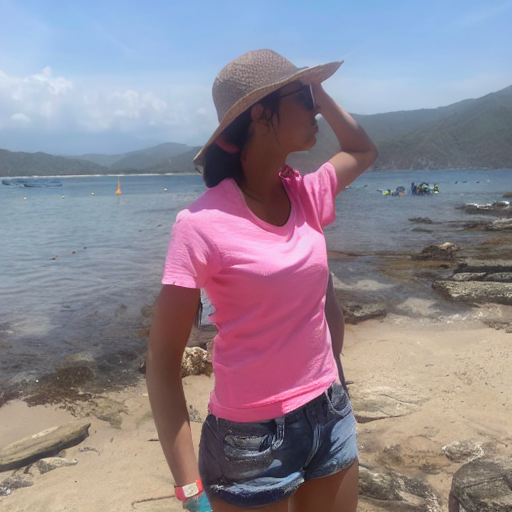

In [18]:
image